In [1443]:
import torch
from torch import nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim.lr_scheduler import CyclicLR, ExponentialLR, ReduceLROnPlateau,StepLR
torch.__version__

'2.5.1+cu121'

# 1. Criando os dados

In [1444]:
# Creating data
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)

y = weight * X + bias
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

## 1.1 Dividindo os dados em dados de treinamento e teste

In [1445]:
# Vamos realizar uma divisão com 80% para treinamento e 20% para teste
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [1446]:
# Função para plotar os dados e as predições
def plot_predictions(train_data=X_train.cpu(), train_labels=y_train.cpu(),test_data=X_test.cpu(), test_labels=y_test.cpu(), predictions=None):

    plt.figure(figsize=(8, 6))


    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")


    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")


    if predictions is not None:

        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")


    plt.legend(prop={"size": 14})

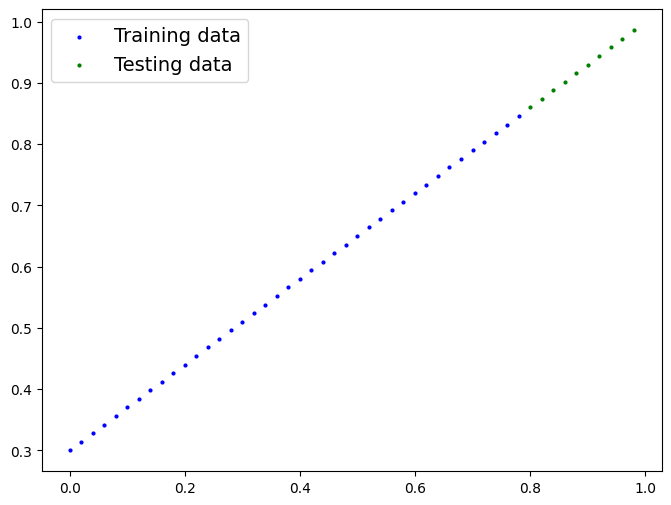

In [1447]:
plot_predictions()

# 2. Criando nosso modelo

In [1448]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  def forward(self, x: torch.tensor):
    return self.weight * x + self.bias

In [1449]:
# Criando o modelo e enviando para o dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)

model_adam = LinearRegressionModel()
model_sgd = LinearRegressionModel()
model_sgd_with_momentum = LinearRegressionModel()
model_sgd_with_nesterov  = LinearRegressionModel()

model_adam.to(device)
model_sgd.to(device)
model_sgd_with_momentum.to(device)
model_sgd_with_nesterov.to(device)

LinearRegressionModel()

# 3. Escolhendo nossa função de perda e nosso otimizador

In [1450]:
def set_otimizer(model, otimizer_type, lr):
  if(otimizer_type == "SGD"):
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
  elif (otimizer_type == "Adam"):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
  elif (otimizer_type == "SGD_with_momentum"):
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=0.9)
  else:
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=0.9, nesterov=True)
  return optimizer

In [1451]:
loss_fn = nn.L1Loss()
optimizer_0 = set_otimizer(model_adam, "Adam", 0.01)
optimizer_1 = set_otimizer(model_sgd, "SGD", 0.01)
optimizer_2 = set_otimizer(model_sgd_with_momentum, "SGD_with_momentum", 0.01)
optimizer_3 = set_otimizer(model_sgd_with_nesterov, "SGD_with_nesterov", 0.01)


# 4. Escolhendo um scheduler

In [1452]:
def set_scheduler (optimizer, scheduler_type):
  if(scheduler_type == "ReduceLROnPlateau"):
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1,  patience=6, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
  elif (  scheduler_type == "ExponentialLR"):
    scheduler = ExponentialLR(optimizer, gamma=0.9)
  else:
    scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
  return scheduler

# 5. Executando o loop de treinamento e teste

In [1453]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [1454]:
def train_model(model, otimizer, scheduler, epochs):
  torch.manual_seed(42)
  epochs = epochs

  w_grads = []
  b_grads = []
  epochs_count = []
  loss_list = []
  test_loss_list = []
  lr_list = []


  for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)

    otimizer.zero_grad()

    loss.backward()

    otimizer.step()

    # Acessando os gradientes dos parâmetros do modelo
    w_grads.append(model.weight.grad.cpu().item())
    b_grads.append(model.bias.grad.cpu().item())
    lr_list.append(otimizer.param_groups[0]['lr'])



    model.eval()
    with torch.inference_mode():
      test_pred = model(X_test)
      test_loss = loss_fn(test_pred, y_test)
      epochs_count.append(epoch)
      loss_list.append(loss)
      test_loss_list.append(test_loss)


    if(scheduler):
      if(isinstance(scheduler, ReduceLROnPlateau)):
        scheduler.step(test_loss)
      else:
        scheduler.step()


    if epoch % 10 == 0:


      print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

  return w_grads, b_grads, epochs_count, loss_list, test_loss_list, lr_list

In [1455]:
m_adam_w_grads, m_adam_b_grads, m_adam_epochs_count, m_adam_losses, m_adam_test_losses, m_adam_lr_list = train_model(model_adam, optimizer_0, None, 100)
m_sgd_w_grads, m_sgd_b_grads, m_sgd_epochs_count, m_sgd_losses, m_sgd_test_losses, m_sgd_lr_list = train_model(model_sgd, optimizer_1, None, 100)
m_sgd_with_momentum_w_grads, m_sgd_with_momentum_b_grads, m_sgd_with_momentum_epochs_count, m_sgd_with_momentum_losses, m_sgd_with_momentum_test_losses, m_sgd_with_momentum_lr_list = train_model(model_sgd_with_momentum, optimizer_2, None, 100)
m_sgd_with_nesterov_w_grads, m_sgd_with_nesterov_b_grads, m_sgd_with_nesterov_epochs_count, m_sgd_with_nesterov_losses, m_sgd_with_nesterov_test_losses, m_sgd_with_nesterov_lr_list = train_model(model_sgd_with_nesterov, optimizer_3, None, 100)

Epoch: 0 | Loss: 0.31288135051727295 | Test loss: 0.47563621401786804
Epoch: 10 | Loss: 0.17388133704662323 | Test loss: 0.28663620352745056
Epoch: 20 | Loss: 0.042198795825242996 | Test loss: 0.0987466350197792
Epoch: 30 | Loss: 0.044207725673913956 | Test loss: 0.005456471350044012
Epoch: 40 | Loss: 0.022640464827418327 | Test loss: 0.0635034516453743
Epoch: 50 | Loss: 0.017085567116737366 | Test loss: 0.0409594364464283
Epoch: 60 | Loss: 0.008707202039659023 | Test loss: 0.013333290815353394
Epoch: 70 | Loss: 0.0023071200121194124 | Test loss: 0.002345198532566428
Epoch: 80 | Loss: 0.0022460997570306063 | Test loss: 0.002025956055149436
Epoch: 90 | Loss: 0.0018262945814058185 | Test loss: 0.0037562549114227295
Epoch: 0 | Loss: 0.25122666358947754 | Test loss: 0.47052446007728577
Epoch: 10 | Loss: 0.14193940162658691 | Test loss: 0.34090352058410645
Epoch: 20 | Loss: 0.09095563739538193 | Test loss: 0.2517373263835907
Epoch: 30 | Loss: 0.07409852743148804 | Test loss: 0.2002120763063

# 6. Realizando predições

In [1456]:
with torch.inference_mode():
  y_preds = model_adam(X_test)
y_preds

tensor([[0.8635],
        [0.8776],
        [0.8917],
        [0.9057],
        [0.9198],
        [0.9339],
        [0.9480],
        [0.9620],
        [0.9761],
        [0.9902]], device='cuda:0')

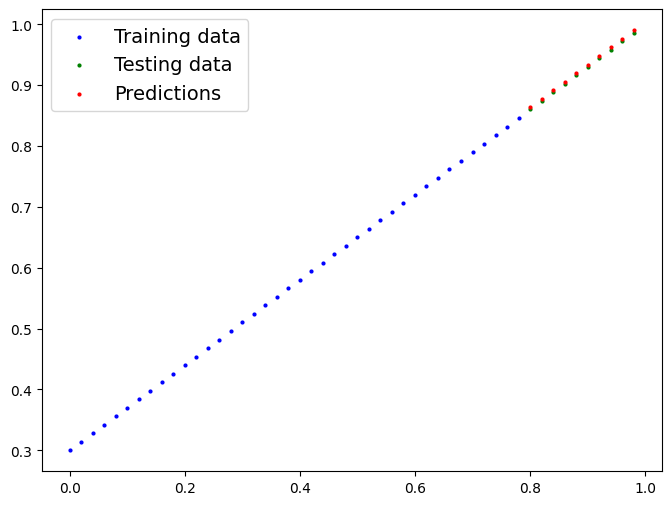

In [1457]:
plot_predictions(predictions=y_preds.cpu())

In [1458]:
with torch.inference_mode():
  y_preds = model_sgd(X_test)
y_preds

tensor([[0.7724],
        [0.7818],
        [0.7912],
        [0.8006],
        [0.8101],
        [0.8195],
        [0.8289],
        [0.8383],
        [0.8477],
        [0.8571]], device='cuda:0')

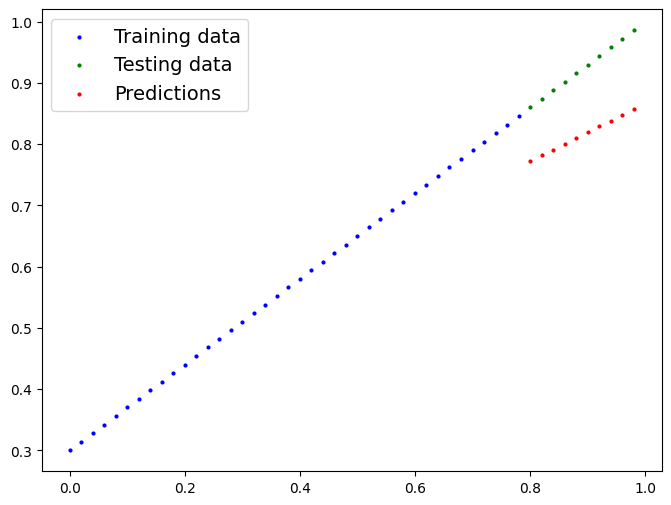

In [1459]:
plot_predictions(predictions=y_preds.cpu())

In [1460]:
with torch.inference_mode():
  y_preds = model_sgd_with_momentum(X_test)
y_preds

tensor([[0.7950],
        [0.8058],
        [0.8166],
        [0.8274],
        [0.8381],
        [0.8489],
        [0.8597],
        [0.8705],
        [0.8813],
        [0.8921]], device='cuda:0')

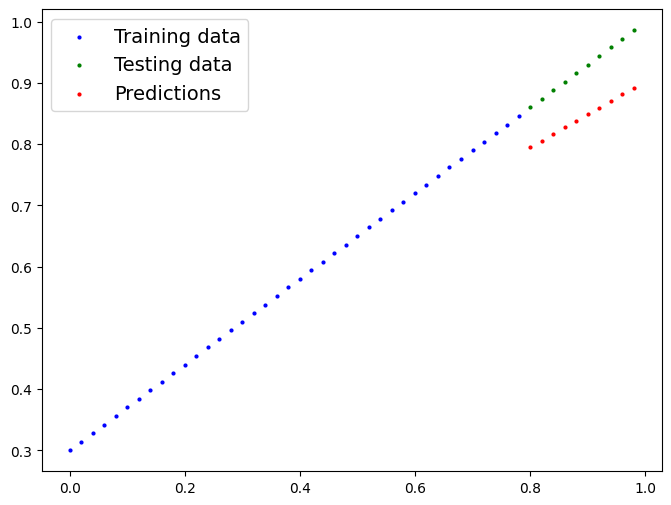

In [1461]:
plot_predictions(predictions=y_preds.cpu())

In [1462]:
with torch.inference_mode():
  y_preds = model_sgd_with_nesterov(X_test)
y_preds

tensor([[0.8880],
        [0.9035],
        [0.9190],
        [0.9345],
        [0.9499],
        [0.9654],
        [0.9809],
        [0.9963],
        [1.0118],
        [1.0273]], device='cuda:0')

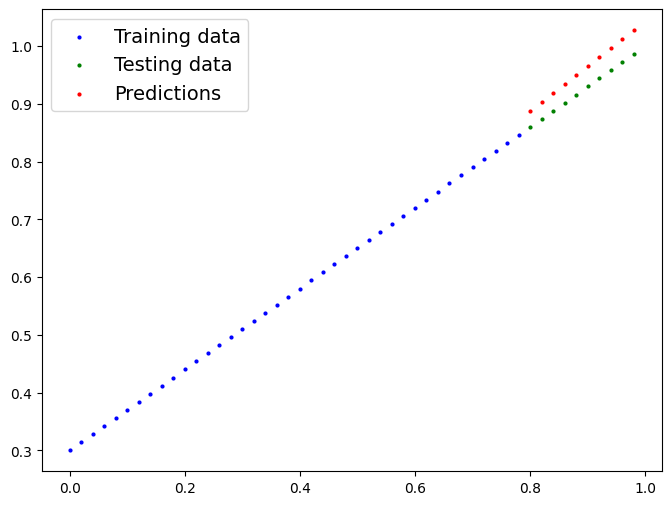

In [1463]:
plot_predictions(predictions=y_preds.cpu())

# 7. Visualizando os gradientes

In [1464]:
import matplotlib.pyplot as plt

def plot_losses_comparison(rows, columns, models, epochs):
    """
    Plota gráficos de perda (loss) de treinamento e validação para qualquer número de modelos.

    Parameters:
    - rows: Número de linhas na grade de subplots.
    - columns: Número de colunas na grade de subplots.
    - models: Lista de dicionários, onde cada dicionário contém:
        - "training_loss": Lista de perdas de treinamento (Tensor ou Numpy).
        - "validation_loss": Lista de perdas de validação (Tensor ou Numpy).
        - "title": Título do gráfico.
    - epochs: Lista de épocas.
    """
    # Configuração da figura e dos subplots
    fig, axes = plt.subplots(rows, columns, figsize=(columns * 4, rows * 3))  # Ajusta tamanho do gráfico
    axes = axes.flatten()  # Para simplificar a indexação dos subplots

    for i, model in enumerate(models):
        # Converter tensores para Numpy Arrays, se necessário
        training_loss = [loss.cpu().detach().numpy() if hasattr(loss, 'cpu') else loss for loss in model["training_loss"]]
        validation_loss = [loss.cpu().detach().numpy() if hasattr(loss, 'cpu') else loss for loss in model["validation_loss"]]

        # Plotar as perdas no subplot correspondente
        axes[i].plot(epochs, training_loss, label="Training Loss", color='blue')
        axes[i].plot(epochs, validation_loss, label="Validation Loss", color='red')
        axes[i].set_title(model["title"])
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel("Loss")
        # axes[i].set_yscale("log")
        axes[i].grid(True, which="both", linestyle='--', linewidth=0.5)
        axes[i].legend()

    # Remover subplots vazios (se houver mais subplots do que modelos)
    for j in range(len(models), len(axes)):
        fig.delaxes(axes[j])

    # Ajustar layout
    plt.tight_layout()
    plt.show()


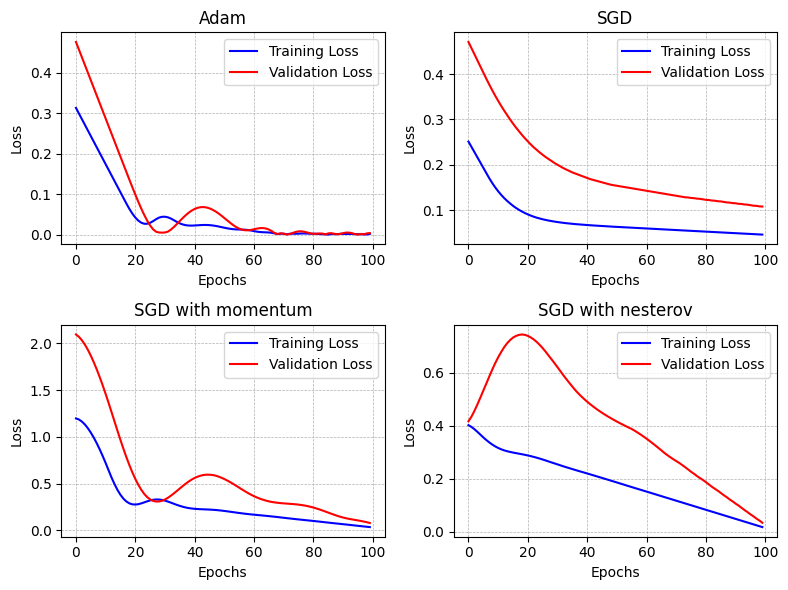

In [1465]:
models = [
    {
        "training_loss": m_adam_losses,
        "validation_loss": m_adam_test_losses,
        "title": "Adam"
    },
    {
         "training_loss": m_sgd_losses,
        "validation_loss": m_sgd_test_losses,
        "title": "SGD"
    },
     {
        "training_loss": m_sgd_with_momentum_losses,
        "validation_loss": m_sgd_with_momentum_test_losses,
        "title": "SGD with momentum"
    },
    {
        "training_loss": m_sgd_with_nesterov_losses,
        "validation_loss": m_sgd_with_nesterov_test_losses,
        "title": "SGD with nesterov"
    },
]

columns = 2
rows = int(len(models)/columns)
epochs = m_adam_epochs_count

plot_losses_comparison(rows=int(len(models)/2), columns=2, models=models, epochs=m_adam_epochs_count)


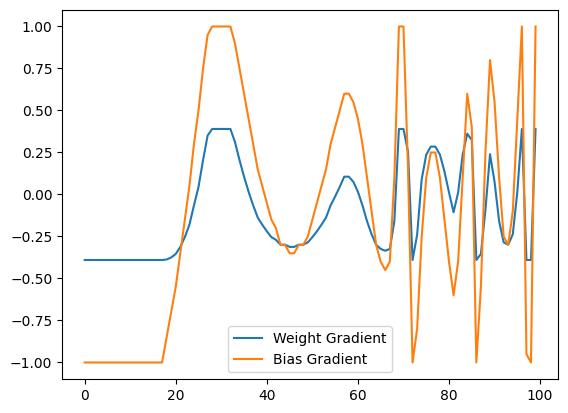

In [1466]:
plt.plot(m_adam_epochs_count, m_adam_w_grads, label="Weight Gradient")
plt.plot(m_adam_epochs_count, m_adam_b_grads, label="Bias Gradient")
plt.legend()

In [1467]:
def plot_loss(epochs, losses, test_losses):
  plt.plot(epochs, np.array(torch.tensor(losses).numpy()), label="Train loss")
  plt.plot(epochs, np.array(torch.tensor(test_losses).numpy()), label="Test loss")
  plt.title("Training and test loss curves")
  plt.ylabel("Loss")
  plt.xlabel("Epochs")

In [1468]:
print("Adam Training Loss:", m_adam_losses[:10])
print("SGD Training Loss:", m_sgd_losses[:10])
print("Adam Testing Loss:", m_adam_test_losses[:10])
print("Sgd Testing Loss:", m_sgd_test_losses[:10])

Adam Training Loss: [tensor(0.3129, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2990, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2851, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2712, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2573, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2434, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2295, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2156, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2017, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1878, device='cuda:0', grad_fn=<MeanBackward0>)]
SGD Training Loss: [tensor(0.2512, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2397, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2282, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2167, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2051, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1936, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.1821, device='cuda:0',

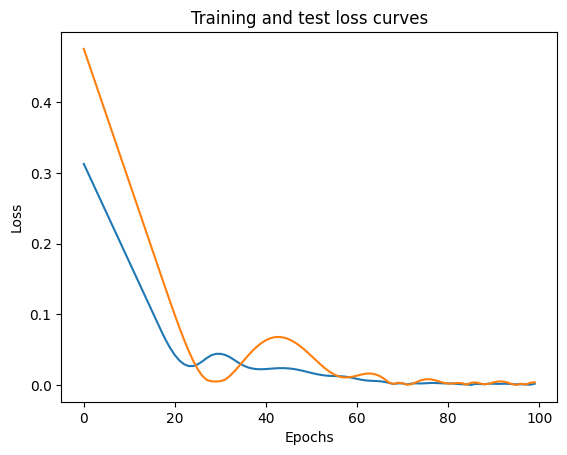

In [1469]:
plot_loss(m_adam_epochs_count, m_adam_losses, m_adam_test_losses)

# 8. Calculando EWMA, Bias corrected EWMA e gradientes adaptados

In [1470]:
def plot_ewma_adapted_gradients(model_grad, model_ewma, model_adapted_grad, epochs):
  plt.plot(epochs, model_adapted_grad, label="Adapted Gradient")
  plt.plot(epochs, model_ewma, label="EWMA")
  plt.plot(epochs, model_grad, label="Gradient")
  plt.title("Gradient vs EWMA vs Adapted Gradient")
  plt.xlabel("Epochs")
  plt.legend()

In [1471]:
def EWMA(past_value, current_value, alpha):
  return (1- alpha) * past_value + alpha * current_value

In [1472]:
def calc_ewma(values, period):
  alpha = 2 / (period + 1)
  result = []
  for v in values:
    try:
      prev_value = result[-1]
    except IndexError:
      prev_value = 0
    new_value = EWMA(prev_value, v, alpha)
    result.append(new_value)
  return np.array(result)


In [1473]:
m_adam_ewma_w = calc_ewma(m_adam_w_grads, 19)
m_adam_ewma_b= calc_ewma(m_adam_b_grads, 19)

In [1474]:
def correction(averaged_value, beta, steps):
  return averaged_value / (1 - (beta ** steps))

def calc_corrected_ewma(values, period):
  ewma = calc_ewma(values, period)
  alpha = 2 / (period + 1)
  beta = 1 - alpha
  result = []
  for step, v in enumerate(ewma):
    adj_value = correction(v, beta, step + 1)
    result.append(adj_value)
  return np.array(result)

In [1475]:
m_adam_corrected_gradients_w = calc_corrected_ewma(m_adam_w_grads, 19)
m_adam_corrected_gradients_b = calc_corrected_ewma(m_adam_b_grads, 19)

m_adam_corrected_sq_gradients_w = calc_corrected_ewma(
np.power(m_adam_w_grads, 2), 1999
)
m_adam_corrected_sq_gradients_b = calc_corrected_ewma(
np.power(m_adam_b_grads, 2), 1999
)

m_adam_adapted_gradients_w = (m_adam_corrected_gradients_w /
(np.sqrt(m_adam_corrected_sq_gradients_w) + 1e-8))
m_adam_adapted_gradients_b = (m_adam_corrected_gradients_b /
(np.sqrt(m_adam_corrected_sq_gradients_b) + 1e-8))

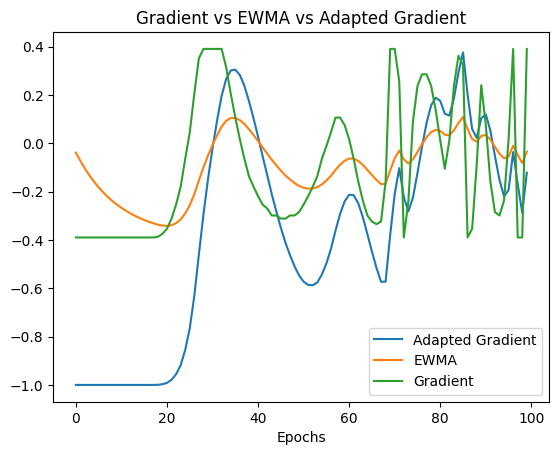

In [1476]:
plot_ewma_adapted_gradients(m_adam_w_grads, m_adam_ewma_w, m_adam_adapted_gradients_w, m_adam_epochs_count)

In [1477]:
def ma_vs_ewma(values, value_label, periods=19):
    ma19 = pd.Series(values).rolling(min_periods=0, window=periods).mean()
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(values, c='k', label=value_label)
    ax.plot(ma19, c='k', linestyle='--', label='MA')
    ax.plot(calc_ewma(values, periods), c='r', linestyle='--', label='EWMA')
    ax.plot(calc_corrected_ewma(values, periods), c='r', linestyle='-', label='Bias-corrected EWMA')
    ax.set_title('MA vs EWMA')
    ax.set_ylabel(value_label)
    ax.set_xlabel('Epochs')
    ax.legend(fontsize=12)
    fig.tight_layout()
    return fig

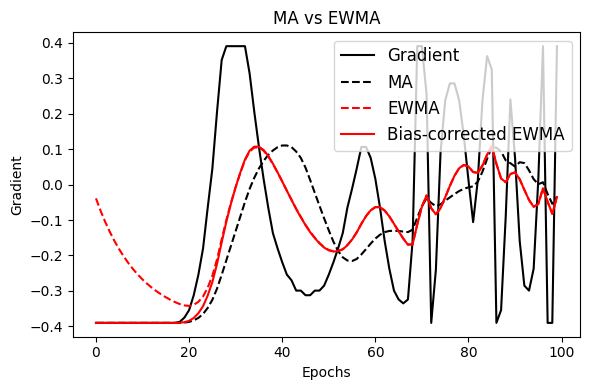

In [1478]:
fig = ma_vs_ewma(m_adam_w_grads, 'Gradient')

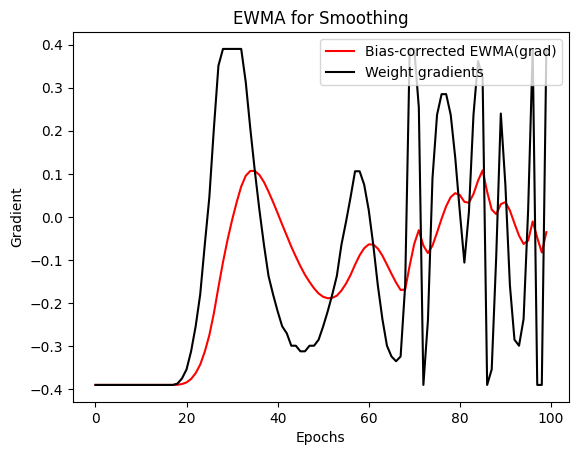

In [1479]:
plt.plot(m_adam_epochs_count, m_adam_corrected_gradients_w, label="Bias-corrected EWMA(grad)", color="red")
plt.plot(m_adam_epochs_count, m_adam_w_grads, label="Weight gradients", color="black")
plt.title('EWMA for Smoothing')
plt.xlabel('Epochs')
plt.ylabel('Gradient')
plt.legend()

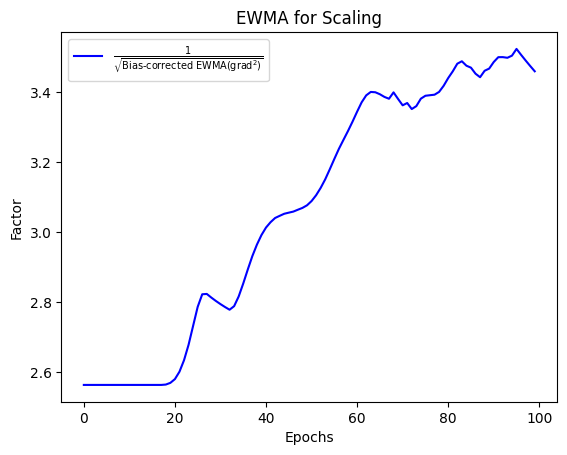

In [1480]:
plt.plot(m_adam_epochs_count, 1/np.sqrt(m_adam_corrected_sq_gradients_w), label=r'$\frac{1}{\sqrt{\text{Bias-corrected EWMA(grad}^2)}}$', color="blue")
plt.title('EWMA for Scaling')
plt.xlabel('Epochs')
plt.ylabel('Factor')
plt.legend()

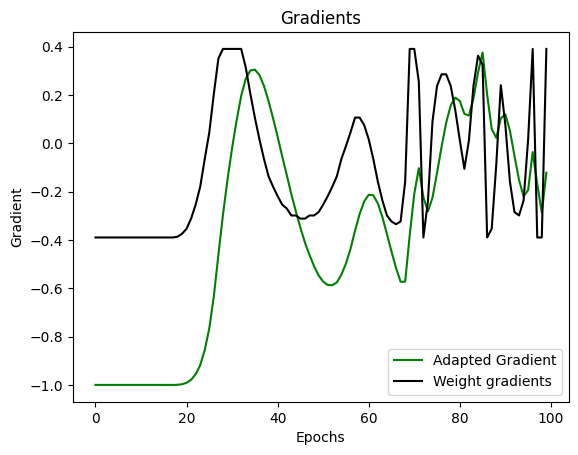

In [1481]:
plt.plot(m_adam_epochs_count, m_adam_adapted_gradients_w, label="Adapted Gradient", color="green")
plt.plot(m_adam_epochs_count, m_adam_w_grads, label="Weight gradients", color="black")
plt.title('Gradients')
plt.xlabel('Epochs')
plt.ylabel('Gradient')
plt.legend()

# 9. Visualizando histórico do learning rate

In [1485]:
def plot_lr_history(epochs, lr_history, scheduler_type):
    plt.plot(epochs, lr_history)
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title(scheduler_type)
    plt.show()

Epoch: 0 | Loss: 0.31288135051727295 | Test loss: 0.47563621401786804
Epoch: 10 | Loss: 0.17388133704662323 | Test loss: 0.28663620352745056
Epoch: 20 | Loss: 0.042198795825242996 | Test loss: 0.0987466350197792
Epoch: 30 | Loss: 0.044207725673913956 | Test loss: 0.005456471350044012
Epoch: 40 | Loss: 0.022989585995674133 | Test loss: 0.04376363381743431
Epoch: 50 | Loss: 0.02255752868950367 | Test loss: 0.04532788321375847
Epoch: 60 | Loss: 0.022541135549545288 | Test loss: 0.045334573835134506
Epoch: 70 | Loss: 0.022540541365742683 | Test loss: 0.04533446952700615
Epoch: 80 | Loss: 0.022540520876646042 | Test loss: 0.045334476977586746
Epoch: 90 | Loss: 0.022540520876646042 | Test loss: 0.045334476977586746


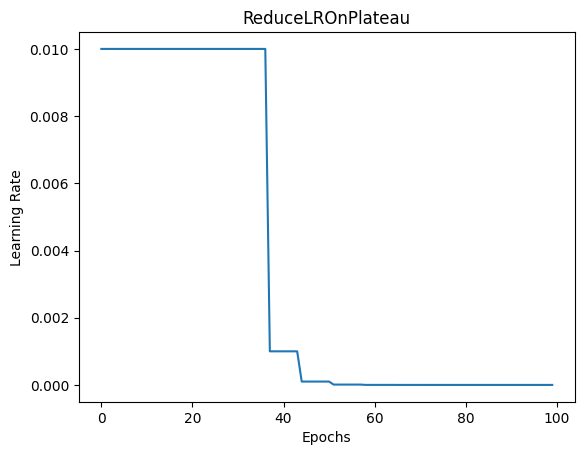

In [1486]:
model_adam_v2 = LinearRegressionModel()
model_adam_v2.to(device)

optimizer_adam = torch.optim.Adam(model_adam_v2.parameters(), lr=0.01)

m_adam_with_scheduler_w_grads, m_adam_with_scheduler_b_grads, m_adam_with_scheduler_epochs_count, m_adam_with_scheduler_losses, m_adam_with_scheduler_test_losses, m_adam_lr_list = train_model(model_adam_v2, optimizer_adam, set_scheduler(optimizer_adam, "ReduceLROnPlateau"), 100)
plot_lr_history(m_adam_with_scheduler_epochs_count, m_adam_lr_list, "ReduceLROnPlateau")

Epoch: 0 | Loss: 0.31288135051727295 | Test loss: 0.47563621401786804
Epoch: 10 | Loss: 0.17388133704662323 | Test loss: 0.2885262072086334
Epoch: 20 | Loss: 0.05192704126238823 | Test loss: 0.12056022137403488
Epoch: 30 | Loss: 0.035565126687288284 | Test loss: 0.012413454242050648
Epoch: 40 | Loss: 0.023426897823810577 | Test loss: 0.04275311902165413
Epoch: 50 | Loss: 0.020774930715560913 | Test loss: 0.05632036551833153
Epoch: 60 | Loss: 0.013907747343182564 | Test loss: 0.027735251933336258
Epoch: 70 | Loss: 0.009192666970193386 | Test loss: 0.01610845886170864
Epoch: 80 | Loss: 0.00426261592656374 | Test loss: 0.009256607852876186
Epoch: 90 | Loss: 0.00037529022665694356 | Test loss: 0.0021677077747881413


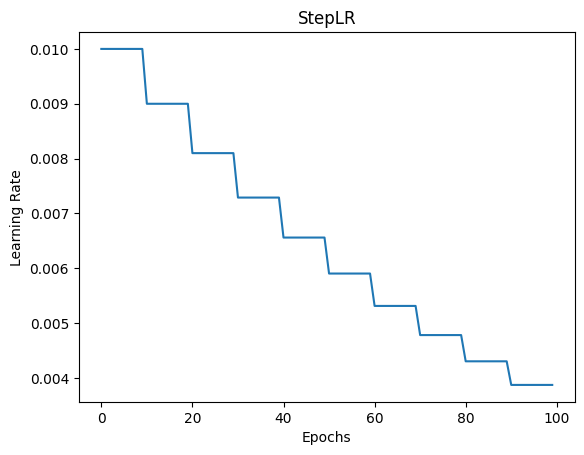

In [1487]:
model_adam_v3 = LinearRegressionModel()
model_adam_v3.to(device)

optimizer_adam = torch.optim.Adam(model_adam_v3.parameters(), lr=0.01)

m_adam_with_scheduler_w_grads, m_adam_with_scheduler_b_grads, m_adam_with_scheduler_epochs_count, m_adam_with_scheduler_losses, m_adam_with_scheduler_test_losses, m_adam_lr_list = train_model(model_adam_v3, optimizer_adam, set_scheduler(optimizer_adam, "StepLR"), 100)
plot_lr_history(m_adam_with_scheduler_epochs_count, m_adam_lr_list, "StepLR")